# Vector Databases: Practical Examples for Software Teams

## Overview
This notebook provides hands-on examples of vector databases and embeddings concepts to complement the AI presentation. We'll explore:

- 🧠 **Understanding Embeddings**: How text becomes numerical vectors
- 🔍 **Semantic Search**: Finding meaning, not just keywords  
- 📚 **RAG Implementation**: Retrieval Augmented Generation in practice
- ⚡ **Performance Comparisons**: Traditional vs Vector search
- 🚀 **Production Tools**: ChromaDB and scaling considerations

---

## Why Vector Databases Matter for Software Teams

**Traditional Problems:**
- Keyword search misses semantic meaning
- Documentation scattered across tools
- Code search limited to exact matches
- Knowledge silos in large codebases

**Vector Database Solutions:**
- Find documents by meaning, not just words
- Semantic code search across repositories  
- Intelligent documentation retrieval
- Context-aware AI assistance (RAG)

## 1. Setup and Dependencies

First, let's install and import the required libraries. Run these cells to set up your environment.

In [1]:
# Install required packages (run once)
# !pip install sentence-transformers chromadb numpy pandas matplotlib seaborn scikit-learn

# If running in Colab, uncomment the line above
# For local environments, install via: pip install sentence-transformers chromadb numpy pandas matplotlib seaborn scikit-learn

print("📦 Installing packages... (uncomment the pip install line above if needed)")
print("✅ Ready to proceed with imports!")

📦 Installing packages... (uncomment the pip install line above if needed)
✅ Ready to proceed with imports!


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Try importing sentence-transformers and chromadb
try:
    from sentence_transformers import SentenceTransformer
    print("✅ sentence-transformers imported successfully")
except ImportError:
    print("❌ sentence-transformers not found. Please install: pip install sentence-transformers")

try:
    import chromadb
    print("✅ chromadb imported successfully")
except ImportError:
    print("❌ chromadb not found. Please install: pip install chromadb")

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("\n🚀 Setup complete! Ready to explore vector databases.")

Matplotlib is building the font cache; this may take a moment.


✅ sentence-transformers imported successfully
✅ chromadb imported successfully

🚀 Setup complete! Ready to explore vector databases.


## 2. Understanding Embeddings

**What are embeddings?** 
Numerical representations of text that capture semantic meaning. Similar texts produce similar vectors.

**Analogy:** Like converting books into unique barcodes based on their content, not just title.

Let's see this in action:

In [10]:
# Load a pre-trained sentence transformer model
# This model converts text to 384-dimensional vectors
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example texts with different semantic meanings
texts = [
    "Python is a programming language",
    "Python is a type of snake", 
    "JavaScript is used for web development",
    "Java is an object-oriented programming language",
    "Snakes are reptiles that slither",
    "Web development involves HTML, CSS, and JavaScript",
    "Machine learning algorithms process data",
    "Data science uses statistics and programming"
]

# Generate embeddings
embeddings = model.encode(texts)

print(f"📊 Generated embeddings:")
print(f"   • Number of texts: {len(texts)}")
print(f"   • Embedding dimensions: {embeddings.shape[1]}")
print(f"   • Shape: {embeddings.shape}")
print(f"\n🔍 Example embedding (first 10 dimensions):")
print(f"   '{texts[0]}' -> {embeddings[0][:10]}")

📊 Generated embeddings:
   • Number of texts: 8
   • Embedding dimensions: 384
   • Shape: (8, 384)

🔍 Example embedding (first 10 dimensions):
   'Python is a programming language' -> [-0.03537081  0.038165   -0.0412601   0.01606883 -0.03836709 -0.13447063
  0.035737    0.04229676 -0.03464682 -0.026432  ]


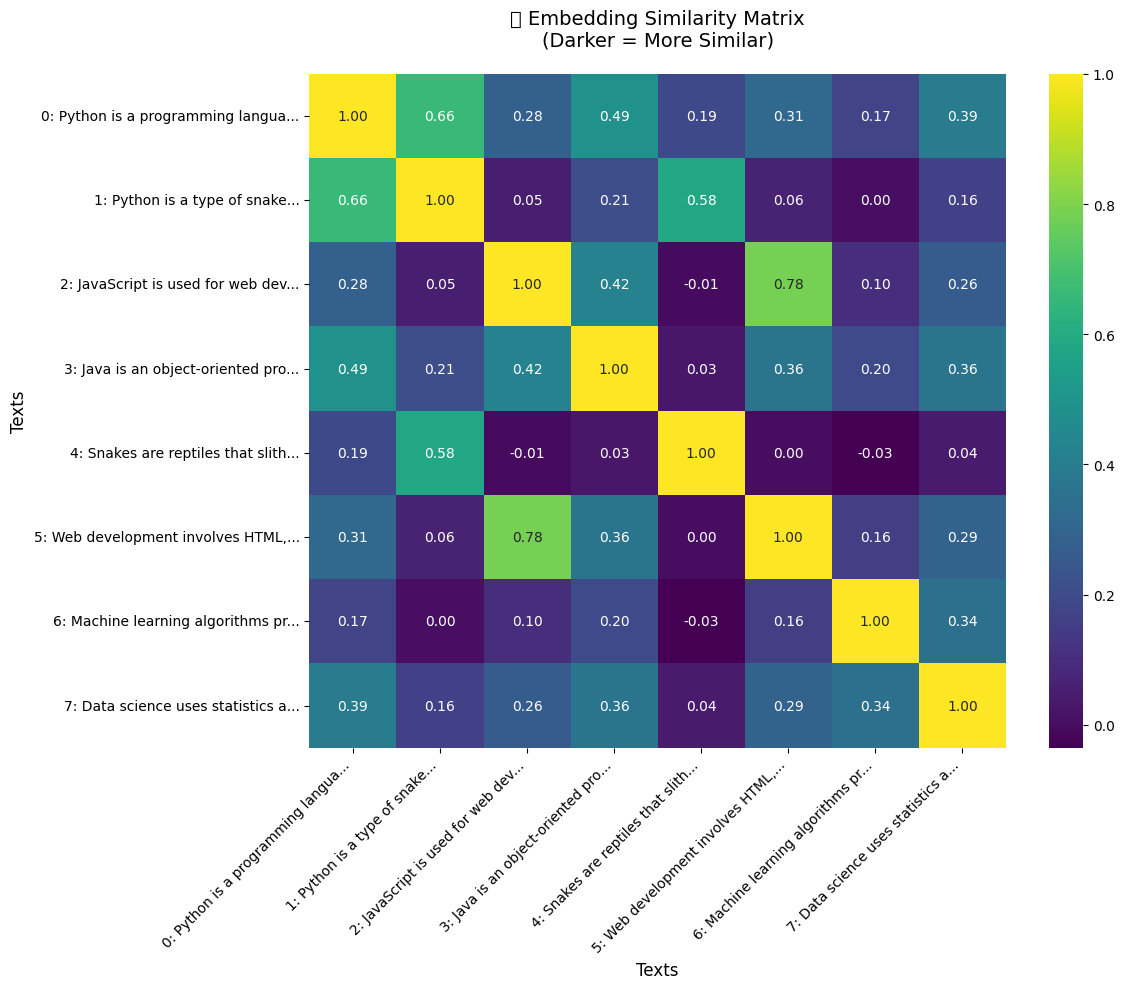

🔍 Key Observations:
   • Programming texts cluster together (higher similarity)
   • 'Python language' vs 'Python snake': 0.663
   • 'Python language' vs 'Java language': 0.486
   • 'Python snake' vs 'Snakes are reptiles': 0.583


In [11]:
# Calculate similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Create a heatmap to visualize similarities
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='viridis',
            xticklabels=[f"{i}: {text[:30]}..." for i, text in enumerate(texts)],
            yticklabels=[f"{i}: {text[:30]}..." for i, text in enumerate(texts)])

plt.title('📊 Embedding Similarity Matrix\n(Darker = More Similar)', fontsize=14, pad=20)
plt.xlabel('Texts', fontsize=12)
plt.ylabel('Texts', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("🔍 Key Observations:")
print(f"   • Programming texts cluster together (higher similarity)")
print(f"   • 'Python language' vs 'Python snake': {similarity_matrix[0][1]:.3f}")
print(f"   • 'Python language' vs 'Java language': {similarity_matrix[0][3]:.3f}")
print(f"   • 'Python snake' vs 'Snakes are reptiles': {similarity_matrix[1][4]:.3f}")

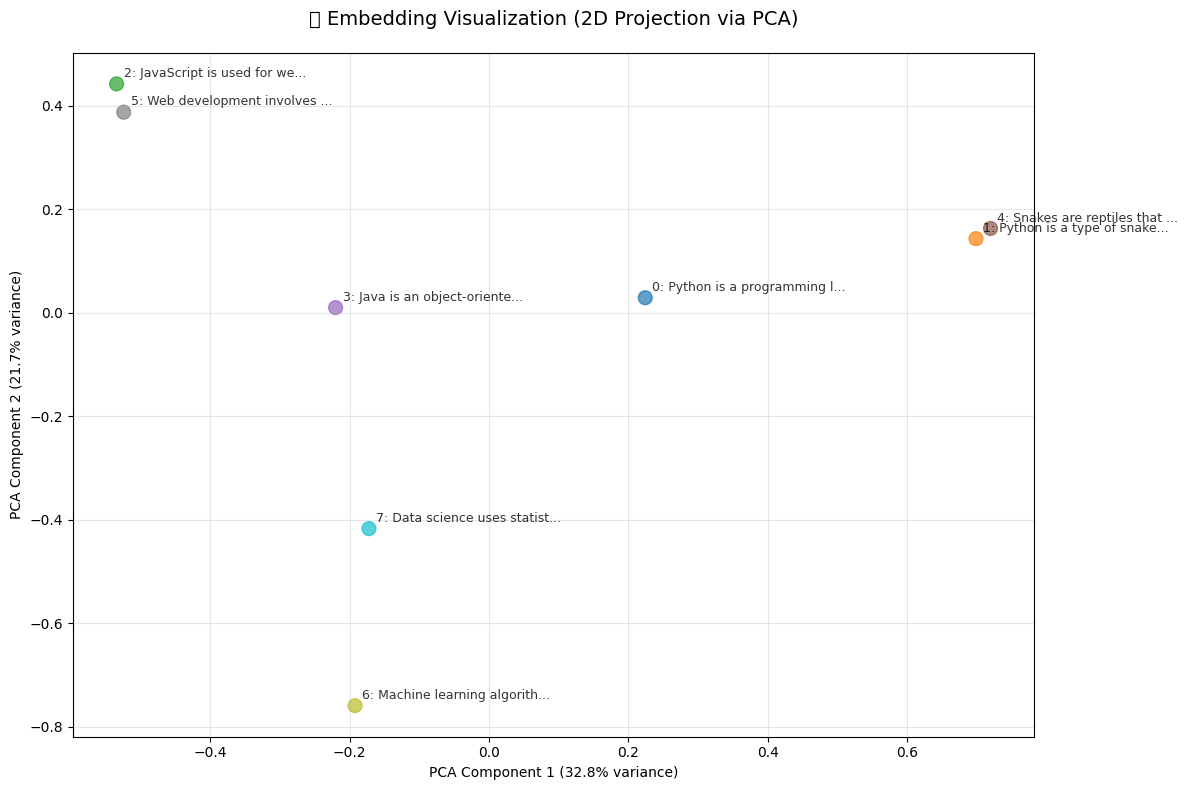

🎯 Notice how semantically similar texts cluster together:
   • Programming languages are grouped
   • Animals/snake references are grouped
   • Web development concepts are grouped


In [6]:
# Visualize embeddings in 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=range(len(texts)), cmap='tab10', s=100, alpha=0.7)

# Add labels for each point
for i, txt in enumerate(texts):
    plt.annotate(f"{i}: {txt[:25]}...", 
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

plt.title('🗺️ Embedding Visualization (2D Projection via PCA)', fontsize=14, pad=20)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🎯 Notice how semantically similar texts cluster together:")
print("   • Programming languages are grouped")
print("   • Animals/snake references are grouped")
print("   • Web development concepts are grouped")

## 3. Creating a Simple Vector Database

Now let's build a basic vector database from scratch using NumPy. This will help understand what happens under the hood.

In [12]:
class SimpleVectorDB:
    """A basic vector database implementation using NumPy"""
    
    def __init__(self, model):
        self.model = model
        self.documents = []
        self.embeddings = None
        
    def add_documents(self, docs):
        """Add documents to the database"""
        self.documents.extend(docs)
        # Generate embeddings for all documents
        all_embeddings = self.model.encode(self.documents)
        self.embeddings = np.array(all_embeddings)
        print(f"✅ Added {len(docs)} documents. Total: {len(self.documents)}")
        
    def search(self, query, top_k=3):
        """Search for similar documents"""
        if self.embeddings is None:
            return []
            
        # Generate embedding for query
        query_embedding = self.model.encode([query])
        
        # Calculate similarities
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        
        # Get top-k most similar
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                'document': self.documents[idx],
                'similarity': similarities[idx],
                'index': idx
            })
            
        return results

# Create our vector database
vector_db = SimpleVectorDB(model)

# Sample software engineering documents
documents = [
    "Python Django REST API development tutorial",
    "React components and state management patterns", 
    "Database schema design best practices",
    "Git branching strategies for team collaboration",
    "Docker containerization for microservices",
    "JavaScript asynchronous programming with promises",
    "SQL query optimization techniques",
    "AWS cloud infrastructure deployment",
    "Test-driven development with Jest and pytest",
    "API authentication using JWT tokens",
    "Redis caching for application performance",
    "Kubernetes container orchestration guide"
]

vector_db.add_documents(documents)
print(f"📚 Vector database ready with {len(documents)} documents!")

✅ Added 12 documents. Total: 12
📚 Vector database ready with 12 documents!


## 4. Semantic Search Implementation

Now let's test our vector database with semantic search queries. Notice how it finds relevant documents even without exact keyword matches!

In [13]:
def demo_search(query, description=""):
    """Demonstrate search results for a query"""
    print(f"\n🔍 Query: '{query}'")
    if description:
        print(f"   📝 {description}")
    
    results = vector_db.search(query, top_k=3)
    
    for i, result in enumerate(results, 1):
        print(f"   {i}. [{result['similarity']:.3f}] {result['document']}")

# Test various semantic search scenarios
demo_search(
    "building web applications", 
    "Should find React, Django, etc. even though query doesn't contain exact words"
)

demo_search(
    "database performance optimization",
    "Should find SQL optimization and caching docs"
)

demo_search(
    "deployment and infrastructure",
    "Should find Docker, AWS, Kubernetes content"
)

demo_search(
    "team development workflow",
    "Should find Git branching and testing practices"
)

demo_search(
    "frontend component architecture",
    "Should prioritize React components over backend topics"
)

print(f"\n💡 Key Insight: Vector search finds semantically related content,")
print(f"    not just exact keyword matches!")


🔍 Query: 'building web applications'
   📝 Should find React, Django, etc. even though query doesn't contain exact words
   1. [0.260] Database schema design best practices
   2. [0.225] Python Django REST API development tutorial
   3. [0.189] AWS cloud infrastructure deployment

🔍 Query: 'database performance optimization'
   📝 Should find SQL optimization and caching docs
   1. [0.730] SQL query optimization techniques
   2. [0.518] Database schema design best practices
   3. [0.376] Redis caching for application performance

🔍 Query: 'deployment and infrastructure'
   📝 Should find Docker, AWS, Kubernetes content
   1. [0.658] AWS cloud infrastructure deployment
   2. [0.331] Docker containerization for microservices
   3. [0.324] Kubernetes container orchestration guide

🔍 Query: 'team development workflow'
   📝 Should find Git branching and testing practices
   1. [0.552] Git branching strategies for team collaboration
   2. [0.277] Test-driven development with Jest and pytest
  

## 5. Document Similarity Analysis

Let's analyze how our documents cluster together and find the most similar pairs. This is useful for organizing documentation, finding duplicates, or understanding topic relationships.

🔗 Most Similar Document Pairs:
1. Similarity: 0.547
   📄 Doc 4: Docker containerization for microservices...
   📄 Doc 11: Kubernetes container orchestration guide...

2. Similarity: 0.393
   📄 Doc 2: Database schema design best practices...
   📄 Doc 6: SQL query optimization techniques...

3. Similarity: 0.376
   📄 Doc 4: Docker containerization for microservices...
   📄 Doc 7: AWS cloud infrastructure deployment...

4. Similarity: 0.357
   📄 Doc 7: AWS cloud infrastructure deployment...
   📄 Doc 11: Kubernetes container orchestration guide...

5. Similarity: 0.264
   📄 Doc 3: Git branching strategies for team collaboration...
   📄 Doc 8: Test-driven development with Jest and pytest...



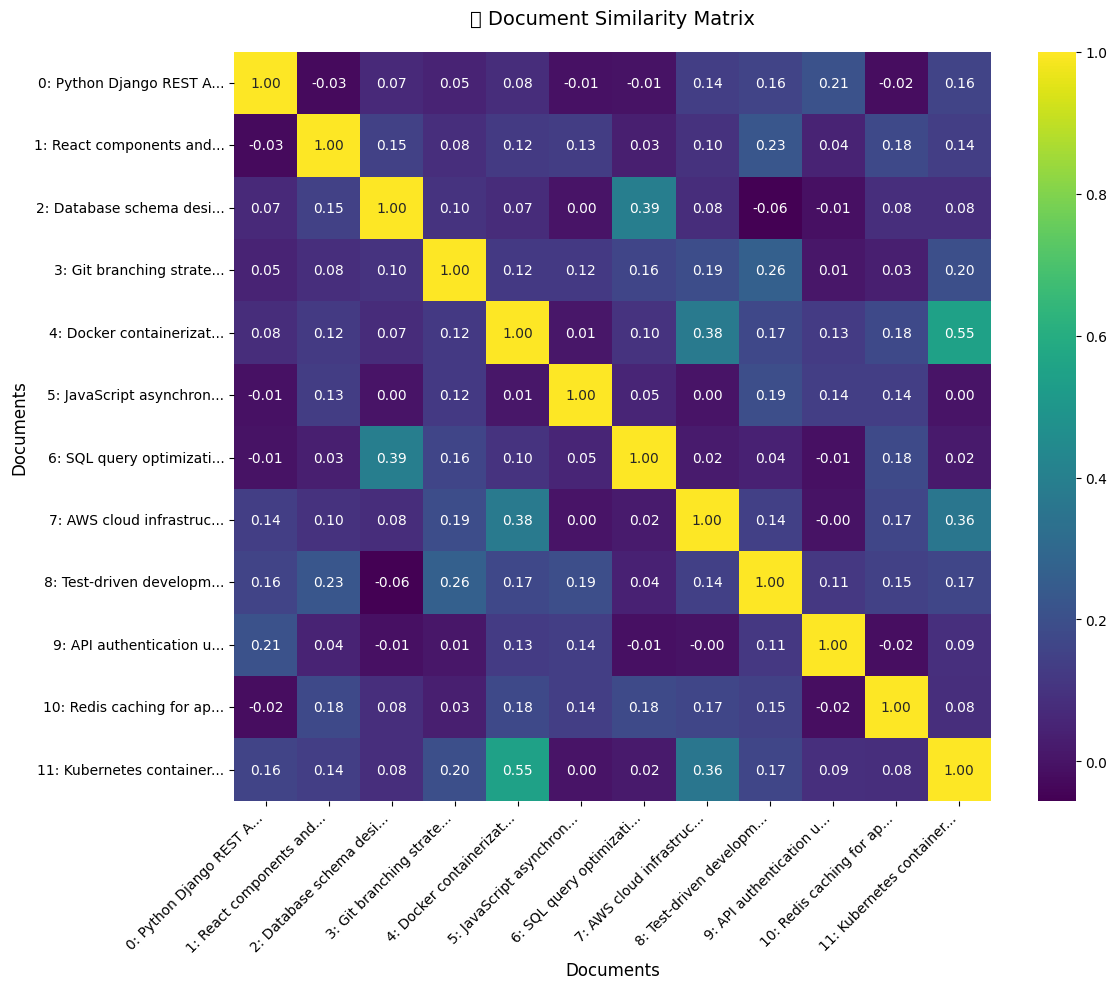

In [14]:
# Calculate similarity matrix for all documents
doc_similarities = cosine_similarity(vector_db.embeddings)

# Find most similar document pairs (excluding self-similarity)
similar_pairs = []
for i in range(len(documents)):
    for j in range(i+1, len(documents)):
        similarity = doc_similarities[i][j]
        similar_pairs.append({
            'doc1_idx': i,
            'doc2_idx': j,
            'doc1': documents[i][:50] + "...",
            'doc2': documents[j][:50] + "...",
            'similarity': similarity
        })

# Sort by similarity and show top pairs
similar_pairs.sort(key=lambda x: x['similarity'], reverse=True)

print("🔗 Most Similar Document Pairs:")
print("=" * 80)
for i, pair in enumerate(similar_pairs[:5], 1):
    print(f"{i}. Similarity: {pair['similarity']:.3f}")
    print(f"   📄 Doc {pair['doc1_idx']}: {pair['doc1']}")
    print(f"   📄 Doc {pair['doc2_idx']}: {pair['doc2']}")
    print()

# Visualize document similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(doc_similarities, 
            annot=True, 
            fmt='.2f', 
            cmap='viridis',
            xticklabels=[f"{i}: {doc[:20]}..." for i, doc in enumerate(documents)],
            yticklabels=[f"{i}: {doc[:20]}..." for i, doc in enumerate(documents)])

plt.title('📊 Document Similarity Matrix', fontsize=14, pad=20)
plt.xlabel('Documents', fontsize=12)
plt.ylabel('Documents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. RAG (Retrieval Augmented Generation) Example

RAG combines vector search with language model generation. Let's build a simple RAG system that retrieves relevant context and generates responses.

**Note:** This example demonstrates the retrieval part. In production, you'd combine this with an LLM API (OpenAI, Anthropic, etc.)

In [15]:
class SimpleRAG:
    """A basic RAG system for demonstration"""
    
    def __init__(self, vector_db):
        self.vector_db = vector_db
        
    def retrieve_context(self, query, top_k=3, min_similarity=0.2):
        """Retrieve relevant context for a query"""
        results = self.vector_db.search(query, top_k=top_k)
        
        # Filter by minimum similarity threshold
        relevant_docs = [
            result for result in results 
            if result['similarity'] >= min_similarity
        ]
        
        return relevant_docs
    
    def generate_response(self, query, context_docs):
        """Generate a response using retrieved context (simplified)"""
        if not context_docs:
            return "I don't have relevant information to answer this question."
        
        # In production, this would call an LLM API
        # For demo, we'll create a structured response
        response = f"Based on the relevant documentation, here's what I found:\n\n"
        
        for i, doc in enumerate(context_docs, 1):
            response += f"{i}. {doc['document']} (relevance: {doc['similarity']:.2f})\n"
        
        response += f"\nThese documents should help with: {query}"
        return response
    
    def answer_question(self, question):
        """Complete RAG pipeline"""
        print(f"🤖 Question: {question}")
        print("=" * 60)
        
        # Step 1: Retrieve relevant context
        context = self.retrieve_context(question)
        print(f"📚 Retrieved {len(context)} relevant documents")
        
        # Step 2: Generate response (simulated)
        response = self.generate_response(question, context)
        print(f"\n💡 Response:\n{response}")
        
        return response

# Create RAG system
rag_system = SimpleRAG(vector_db)

# Test questions
questions = [
    "How do I deploy my application?",
    "What's the best way to manage state in frontend?",
    "How can I optimize database performance?",
    "What testing strategies should I use?"
]

for question in questions:
    rag_system.answer_question(question)
    print("\n" + "="*80 + "\n")

🤖 Question: How do I deploy my application?
📚 Retrieved 2 relevant documents

💡 Response:
Based on the relevant documentation, here's what I found:

1. AWS cloud infrastructure deployment (relevance: 0.36)
2. Kubernetes container orchestration guide (relevance: 0.26)

These documents should help with: How do I deploy my application?


🤖 Question: What's the best way to manage state in frontend?
📚 Retrieved 3 relevant documents

💡 Response:
Based on the relevant documentation, here's what I found:

1. React components and state management patterns (relevance: 0.59)
2. Redis caching for application performance (relevance: 0.23)
3. Database schema design best practices (relevance: 0.20)

These documents should help with: What's the best way to manage state in frontend?


🤖 Question: How can I optimize database performance?
📚 Retrieved 3 relevant documents

💡 Response:
Based on the relevant documentation, here's what I found:

1. SQL query optimization techniques (relevance: 0.66)
2. Datab

## 7. Performance Comparison: Traditional vs Vector Search

Let's compare traditional keyword-based search with our vector-based semantic search to see the difference in results quality.

In [16]:
def keyword_search(query, documents, top_k=3):
    """Traditional keyword-based search"""
    query_words = set(query.lower().split())
    
    # Calculate keyword overlap scores
    scores = []
    for i, doc in enumerate(documents):
        doc_words = set(doc.lower().split())
        overlap = len(query_words.intersection(doc_words))
        scores.append((i, overlap, doc))
    
    # Sort by overlap score
    scores.sort(key=lambda x: x[1], reverse=True)
    
    return [{'document': score[2], 'score': score[1], 'index': score[0]} 
            for score in scores[:top_k]]

def compare_search_methods(query):
    """Compare keyword vs vector search"""
    print(f"\n🔍 Query: '{query}'")
    print("=" * 60)
    
    # Keyword search
    keyword_results = keyword_search(query, documents)
    print("📝 Traditional Keyword Search Results:")
    for i, result in enumerate(keyword_results, 1):
        print(f"   {i}. [Score: {result['score']}] {result['document']}")
    
    print()
    
    # Vector search  
    vector_results = vector_db.search(query, top_k=3)
    print("🧠 Vector Semantic Search Results:")
    for i, result in enumerate(vector_results, 1):
        print(f"   {i}. [Similarity: {result['similarity']:.3f}] {result['document']}")

# Test queries that show the difference
test_queries = [
    "building web apps",  # No exact matches but clear semantic intent
    "performance optimization",  # Semantic concept
    "team workflow",  # Abstract concept
    "frontend development"  # Semantic category
]

for query in test_queries:
    compare_search_methods(query)
    print("\n" + "-" * 80)


🔍 Query: 'building web apps'
📝 Traditional Keyword Search Results:
   1. [Score: 0] Python Django REST API development tutorial
   2. [Score: 0] React components and state management patterns
   3. [Score: 0] Database schema design best practices

🧠 Vector Semantic Search Results:
   1. [Similarity: 0.275] Python Django REST API development tutorial
   2. [Similarity: 0.200] AWS cloud infrastructure deployment
   3. [Similarity: 0.200] Test-driven development with Jest and pytest

--------------------------------------------------------------------------------

🔍 Query: 'performance optimization'
📝 Traditional Keyword Search Results:
   1. [Score: 1] SQL query optimization techniques
   2. [Score: 1] Redis caching for application performance
   3. [Score: 0] Python Django REST API development tutorial

🧠 Vector Semantic Search Results:
   1. [Similarity: 0.569] SQL query optimization techniques
   2. [Similarity: 0.355] Redis caching for application performance
   3. [Similarity: 0.18

In [17]:
# Analysis of search method effectiveness
print("📊 Key Differences Between Search Methods:")
print("=" * 60)
print("🔤 Keyword Search:")
print("   • Exact word matching only")
print("   • Misses synonyms and related concepts")
print("   • Simple to implement and understand") 
print("   • Fast for exact matches")
print("   • Poor with typos or alternative phrasings")

print("\n🧠 Vector Search:")
print("   • Understands semantic meaning")
print("   • Finds related concepts even without exact words")
print("   • Better for natural language queries")
print("   • Handles synonyms and context")
print("   • More computationally intensive")

print("\n💡 When to Use Each:")
print("   • Keyword: Exact term lookup, structured data")
print("   • Vector: Natural language, concept search, AI applications")

📊 Key Differences Between Search Methods:
🔤 Keyword Search:
   • Exact word matching only
   • Misses synonyms and related concepts
   • Simple to implement and understand
   • Fast for exact matches
   • Poor with typos or alternative phrasings

🧠 Vector Search:
   • Understands semantic meaning
   • Finds related concepts even without exact words
   • Better for natural language queries
   • Handles synonyms and context
   • More computationally intensive

💡 When to Use Each:
   • Keyword: Exact term lookup, structured data
   • Vector: Natural language, concept search, AI applications


## 8. Production Considerations with ChromaDB

For production applications, you'll want a more robust vector database. Let's explore ChromaDB, a production-ready option that's easy to get started with.

In [ ]:
# Production-ready vector database with ChromaDB
try:
    import chromadb
    from chromadb.config import Settings
    
    # Create a persistent ChromaDB client
    client = chromadb.Client(Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory="./chroma_db"  # Persist data to disk
    ))
    
    # Create or get a collection
    collection_name = "software_docs"
    collection = client.get_or_create_collection(
        name=collection_name,
        metadata={"description": "Software engineering documentation"}
    )
    
    # Add documents with metadata
    doc_ids = [f"doc_{i}" for i in range(len(documents))]
    doc_metadata = [
        {"category": "web", "language": "python"} if "Django" in doc or "React" in doc
        else {"category": "database", "language": "sql"} if "SQL" in doc or "database" in doc
        else {"category": "devops", "language": "general"} if "Docker" in doc or "AWS" in doc or "Kubernetes" in doc
        else {"category": "development", "language": "general"}
        for doc in documents
    ]
    
    # Add documents to collection
    collection.add(
        documents=documents,
        metadatas=doc_metadata,
        ids=doc_ids
    )
    
    print(f"✅ Added {len(documents)} documents to ChromaDB collection")
    print(f"📊 Collection stats: {collection.count()} total documents")
    
    # Demonstrate advanced querying with metadata filtering
    def advanced_search(query, category_filter=None, n_results=3):
        """Advanced search with metadata filtering"""
        where_clause = {"category": category_filter} if category_filter else None
        
        results = collection.query(
            query_texts=[query],
            n_results=n_results,
            where=where_clause
        )
        
        print(f"\n🔍 Query: '{query}'")
        if category_filter:
            print(f"   📂 Filtered by category: {category_filter}")
            
        for i, (doc, metadata, distance) in enumerate(zip(
            results['documents'][0], 
            results['metadatas'][0],
            results['distances'][0]
        ), 1):
            similarity = 1 - distance  # Convert distance to similarity
            print(f"   {i}. [{similarity:.3f}] {doc}")
            print(f"      📁 {metadata['category']} | 💻 {metadata['language']}")
    
    # Test advanced search capabilities
    advanced_search("web development")
    advanced_search("database optimization", category_filter="database")
    advanced_search("deployment", category_filter="devops")
    
except ImportError:
    print("❌ ChromaDB not available. Install with: pip install chromadb")
    print("💡 Continuing with our simple vector database instead...")

In [ ]:
# Production Scaling Considerations
print("🚀 Production Vector Database Considerations")
print("=" * 50)

considerations = {
    "Performance": [
        "• Index type selection (HNSW, IVF, etc.)",
        "• Batch operations for large datasets", 
        "• Caching frequently accessed vectors",
        "• GPU acceleration for large-scale search"
    ],
    "Scalability": [
        "• Horizontal sharding across multiple nodes",
        "• Load balancing for query distribution",
        "• Incremental indexing for real-time updates",
        "• Distributed storage backends"
    ],
    "Data Management": [
        "• Version control for embeddings",
        "• Backup and disaster recovery",
        "• Data lifecycle management",
        "• Monitoring and alerting"
    ],
    "Cost Optimization": [
        "• Embedding model selection vs accuracy tradeoff",
        "• Storage optimization (compression, quantization)",
        "• Query optimization and caching",
        "• Resource usage monitoring"
    ]
}

for category, items in considerations.items():
    print(f"\n📋 {category}:")
    for item in items:
        print(f"   {item}")

print(f"\n🛠️ Popular Production Vector Databases:")
databases = [
    "• ChromaDB - Open source, easy to start",
    "• Pinecone - Managed, serverless",
    "• Weaviate - GraphQL interface, multi-modal",
    "• Qdrant - High performance, Rust-based",
    "• Milvus - Open source, highly scalable",
    "• Redis Vector Search - If already using Redis",
    "• PostgreSQL pgvector - If already using PostgreSQL"
]

for db in databases:
    print(f"   {db}")

print(f"\n💡 Selection Criteria:")
print(f"   • Data volume and query patterns")
print(f"   • Integration with existing infrastructure") 
print(f"   • Budget and operational complexity")
print(f"   • Performance requirements")
print(f"   • Team expertise and support needs")

## 🎯 Key Takeaways

### What We've Learned
1. **Embeddings** convert text into numerical vectors that capture semantic meaning
2. **Vector databases** enable similarity search based on meaning, not just keywords
3. **Semantic search** finds relevant content even without exact word matches
4. **RAG systems** combine retrieval with generation for intelligent responses
5. **Production considerations** include performance, scalability, and cost optimization

### Practical Applications for Software Teams

**Documentation & Knowledge Management:**
- Semantic search across technical documentation
- Find related code examples and tutorials
- Intelligent Q&A systems for team knowledge

**Code Intelligence:**
- Similar function/component discovery
- Code documentation and comment search
- Architecture pattern identification

**Customer Support:**
- Intelligent ticket routing and responses
- Knowledge base search and retrieval
- Automated response suggestions

### Next Steps
1. **Start Small**: Try ChromaDB or similar tools with your existing documentation
2. **Experiment**: Test different embedding models for your domain
3. **Measure**: Compare search quality vs traditional methods
4. **Scale**: Consider production requirements as usage grows
5. **Integrate**: Connect with LLMs for full RAG capabilities

---

### Resources for Further Learning
- [ChromaDB Documentation](https://docs.trychroma.com/)
- [Sentence Transformers Models](https://huggingface.co/sentence-transformers)
- [Vector Database Comparison](https://github.com/erikbern/ann-benchmarks)
- [RAG Best Practices](https://docs.anthropic.com/claude/docs/building-with-claude)

---

**Remember**: Vector databases are a powerful tool for making AI applications more context-aware and intelligent. Start with simple use cases and gradually expand as you gain experience! 🚀